In [1]:
import torch

import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [51]:
def dist_metric(x,y):
    return(torch.norm(x-y).item())

def calculate_action(dist_list,k):
    action = torch.tensor([0.0,0.0,0.0])
    top_k_weights = torch.zeros((k,))
    for i in range(k):
        top_k_weights[i] = dist_list[i][0]

    top_k_weights = softmax(-1*top_k_weights)
    for i in range(k):
        action = torch.add(top_k_weights[i]*dist_list[i][1], action)

    return(action)

def extract_image(full_path):
    parts = full_path.split('/')
    return '/'.join(parts[-2:])

In [52]:
params = {}
params['root_dir'] = '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/'  #'/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/' # This was changed
params['img_size'] = 624
params['layer'] = 'avgpool'
params['model'] = 'ImageNet'
params['representation_model_path'] = 'chkpts/BYOL_100_X_pretrained_1.pt' # This was changed
params['eval'] = 0
params['representation'] = 0
params['dataset'] = 'X_Datasets'
params['architecture'] = 'ResNet'
params['t'] = 0
 

sys.path.append(params['root_dir'] + 'representation_models')
sys.path.append(params['root_dir'] + 'dataloaders')
print
from run_model import Encoder
from XDataset import XDataset

encoder = Encoder(params)
params['folder'] =  '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all' # '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all'
train_dataset = XDataset(params, encoder)
params['folder'] =  '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all'# '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all_trial'
val_dataset = XDataset(params, encoder)

/home/aesee/anaconda3/envs/IntroDL/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aesee/anaconda3/envs/IntroDL/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


hi


  0%|          | 0/48 [00:00<?, ?it/s]/home/aesee/anaconda3/envs/IntroDL/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


In [54]:
mseLoss = torch.nn.MSELoss()
ceLoss = torch.nn.CrossEntropyLoss()

softmax = torch.nn.Softmax(dim=0)

In [63]:
def calculate_nearest_neighbors(query_set, dataset, k):
    loss = [0 for i in range(k)]
    selected_paths = []
    for query_index in tqdm(range(len(query_set))):
        dist_list = []
        query_embedding, query_translation, query_rotation, query_gripper, query_path = query_set[query_index]

        for dataset_index in range(len(dataset)):

            dataset_embedding, dataset_translation, dataset_rotation, dataset_gripper, dataset_path = dataset[dataset_index]
            distance = dist_metric(query_embedding, dataset_embedding)
            dist_list.append((distance, dataset_translation, dataset_path))

        dist_list = sorted(dist_list, key = lambda tup: tup[0])
        
        for i in range(k):
            pred_action = calculate_action(dist_list, i+1)
            loss[i] += mseLoss(pred_action,query_translation).item()
            if i == 10:
                selected_paths.append((extract_image(query_path), [extract_image(dist_list[j][2]) for j in range(i+1)]))

        

    return(loss, selected_paths)

In [64]:
val_loss, paths = calculate_nearest_neighbors(val_dataset, train_dataset, 50)

100%|██████████| 80/80 [00:00<00:00, 117.74it/s]


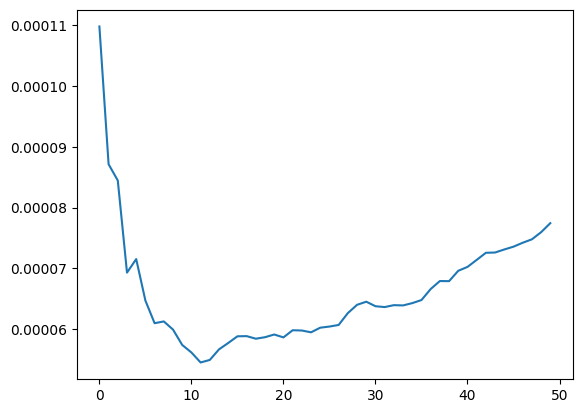

In [66]:
val_loss_scaled = [i / len(val_dataset) for i in val_loss]
x_axis = [i for i in range(len(val_loss))]
plt.plot(x_axis, val_loss_scaled)

In [65]:
print(paths[0])

('run_27/0006.jpg', ['run_26/0005.jpg', 'run_21/0003.jpg', 'run_26/0007.jpg', 'run_28/0006.jpg', 'run_26/0006.jpg', 'run_29/0006.jpg', 'run_25/0005.jpg', 'run_28/0003.jpg', 'run_28/0007.jpg', 'run_29/0005.jpg', 'run_21/0005.jpg'])


In [8]:
import numpy as np
np.argmin(np.array(val_loss_scaled))

11

In [9]:
# test_loss = calculate_nearest_neighbors(test_dataset, train_dataset, 50)

NameError: name 'test_dataset' is not defined

In [ ]:
test_loss_scaled = [i / len(test_dataset) for i in test_loss]
x_axis = [i for i in range(len(test_loss))]
plt.plot(x_axis, test_loss_scaled)

In [ ]:
min(test_loss_scaled)

0.19428218364976935